In [84]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.integrate as integrate
import numpy.linalg as linalg
import scipy.sparse as sparse
from scipy.sparse import csr_matrix
import time
from numpy import genfromtxt

import cProfile
from matplotlib.colors import LightSource
import timeit

#scipy sims

In [85]:
electron_density=np.genfromtxt("electronDensity.csv", delimiter=",")

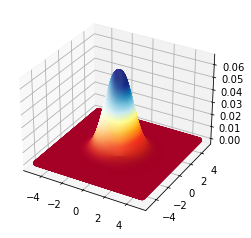

In [86]:
Test.plotList(-5,5,-5,5,electron_density)

In [87]:
class Point:
    def __init__(self, x, y):
        self.x=x
        self.y=y
        
class Triangle:
    #p_3 is the "tip" i.e. point in the middle of element, p_1 and p_2 are the other two verticies. doesnt matter which order
    def __init__(self, p_1, p_2, p_3):
        self.p1=p_1
        self.p2=p_2
        self.p3=p_3
        self.A=self.area();
        
    '''area of this triangle'''
    def area(self):
        p1x, p1y, p2x, p2y, p3x, p3y=self.p1.x, self.p1.y,self.p2.x,self.p2.y,self.p3.x,self.p3.y
        return 0.5*np.abs((p1x*p2y+p3x*p1y+p2x*p3y-p1y*p2x-p2y*p3x-p3y*p1x))
    
    '''finds the area given the point p3 as the new vertex'''
    def area_pt(self,p3):
        return 0.5*np.abs((self.p1.x*self.p2.y+p3.x*self.p1.y+self.p2.x*p3.y-self.p1.y*self.p2.x-self.p2.y*p3.x-p3.y*self.p1.x))
    
    def area_pt_signed(self, p3):
        return 0.5*((self.p1.x*self.p2.y+p3.x*self.p1.y+self.p2.x*p3.y-self.p1.y*self.p2.x-self.p2.y*p3.x-p3.y*self.p1.x))
    
    '''defines if the point x y is in the triangle. if not then returns false otherwise true'''
    '''source: https://stackoverflow.com/questions/2049582/how-to-determine-if-a-point-is-in-a-2d-triangle'''
    def is_in(self,x, y):
        p1x, p1y, p2x, p2y, p3x, p3y=self.p1.x, self.p1.y,self.p2.x,self.p2.y,self.p3.x,self.p3.y
        Area= 0.5 *(-p2y*p3x + p1y*(-p2x + p3x) + p1x*(p2y - p3y) + p2x*p3y)
        s = 1/(2*Area)*(p1y*p3x - p1x*p3y + (p3y - p1y)*x + (p1x - p3x)*y);
        t = 1/(2*Area)*(p1x*p2y - p1y*p2x + (p1y - p2y)*x + (p2x - p1x)*y);
        return 0<=s and t>=0 and 1-s-t>=0

    def evaluate(self,x,y):
        return self.area_pt(Point(x, y))/self.A if self.is_in(x,y) else 0
    
class FiniteElement:
    #top left corner
    def __init__(self, x, y, deltaX, deltaY, config):
        self.deltaX=deltaX
        self.deltaY=deltaY
        
        p1=Point(x, y)
        p2=Point(x+deltaX, y)
        p3=Point(x+2*deltaX, y)
        
        p4=Point(x, y-deltaY)
        center=Point(x+deltaX, y-deltaY)
        p5=Point(x+2*deltaX, y-deltaY)
        
        p6=Point(x, y-2*deltaY)
        p7=Point(x+deltaX, y-2*deltaY)
        p8=Point(x+2*deltaX, y-2*deltaY)
        
        self.triangles=[];
        self.center=center
        self.config=config
        
        if(config==0):
        
            #top left
            self.tri_tl=Triangle(p2,p4,center)

            #top right
            self.tri_tr=Triangle(p2,p5,center)

            #bottom left
            self.tri_bl=Triangle(p4, p7, center)

            #bottom right
            self.tri_br=Triangle(p5,p7,center)
            self.triangles.append(self.tri_tl)
            self.triangles.append(self.tri_tr)
            self.triangles.append(self.tri_bl)
            self.triangles.append(self.tri_br)

        elif(config==1):
            self.tri_tl=Triangle(p1,p2,center)

            self.tri_ul=Triangle(p1, p4, center)

            self.tri_ll=Triangle(p4, p6, center)

            #top right
            self.tri_tr=Triangle(p2,p3,center)

            self.tri_ur=Triangle(p3, p5, center)

            self.tri_lr=Triangle(p5, p8, center)


            #bottom left
            self.tri_bl=Triangle(p6, p7, center)

            #bottom right
            self.tri_br=Triangle(p7,p8,center)
            self.triangles.append(self.tri_tl)
            self.triangles.append(self.tri_tr)
            self.triangles.append(self.tri_bl)
            self.triangles.append(self.tri_br)
            self.triangles.append(self.tri_ll)
            self.triangles.append(self.tri_lr)
            self.triangles.append(self.tri_ul)
            self.triangles.append(self.tri_ur)
        else:
            self.tri_tl=Triangle(p1,p2,center)
            self.tri_ul=Triangle(p1, p4, center)
            self.tri_ll=Triangle(p4,p7, center)
            self.tri_tr=Triangle(p2,p5,center)
            self.tri_lr=Triangle(p5,p8,center)
            self.tri_br=Triangle(p7,p8,center)
            
            self.triangles.append(self.tri_tl)
            self.triangles.append(self.tri_ul)
            self.triangles.append(self.tri_ll)
            self.triangles.append(self.tri_tr)
            self.triangles.append(self.tri_lr)
            self.triangles.append(self.tri_br)
            
        self.top_left_x=x
        self.top_left_y=y
        
    def in_region_1(self, x, y):
        return x<self.top_left_x+self.deltaX and y>=self.top_left_y-self.deltaY
    
    def in_region_2(self,x, y):
        return x>=self.top_left_x+self.deltaX and y>=self.top_left_y-self.deltaY
    
    def in_region_3(self,x, y):
        return x<self.top_left_x+self.deltaX and y<self.top_left_y-self.deltaY
    
    def in_region_4(self,x, y):
        return x>=self.top_left_x+self.deltaX and y<self.top_left_y-self.deltaY
    
    def is_outside(self, x, y):
        return x<=self.top_left_x or y>=self.top_left_y or y<=self.top_left_y-self.deltaY*2 or x>=self.top_left_x+2*self.deltaX
    
    def evaluate(self, x, y):
        thesum=0
        i=0
        tri=self.triangles
        while i<len(tri):
            thesum+=tri[i].evaluate(x, y)
            if(thesum>0):
                return thesum 
            i+=1           
        return thesum
    
    def integrate(self):
        minY=self.top_left_y-2*self.deltaY
        maxY=self.top_left_y
        minX=self.top_left_x
        maxX=self.top_left_x+2*self.deltaX
        return integrate.dblquad(self.evaluate, minY, maxY,lambda x: minX, lambda x: maxX,epsabs=1e-4)[0]
    
class FEM:
    def __init__(self, N, M, minX, maxX, minY, maxY, electronDensity, eps, boundaryCondition, electronDensityList=None):
        self.N=N
        self.M=M
        self.minX=minX
        self.maxX=maxX
        self.minY=minY
        self.maxY=maxY
        self.deltaX=(maxX-minX)/N
        self.deltaY=(maxY-minY)/M
        #function
        self.electronDensity=electronDensity
        self.finiteElements=self.generateFiniteElements();
        self.eps=eps
        self.boundaryCondition=boundaryCondition
        self.electronDensityList=electronDensityList
        temp=self.finiteElements[0, 0]
        self.finiteElemIntIntegral=integrate.dblquad(temp.evaluate, temp.top_left_y-2*self.deltaY, temp.top_left_y, lambda x: temp.top_left_x, lambda x: temp.top_left_x+self.deltaX*2, epsabs=1e-4)[0]
        #does not generate the boundary finite elements!
        
    def generateFiniteElements(self):
        finiteElements=np.ndarray(shape=(self.M-1,self.N-1), dtype=FiniteElement)
        for m in range(0,self.M-1):
            #ignore the last row
            for n in range(0,self.N-1):
                finiteElements[m, n]=FiniteElement(self.minX+n*self.deltaX, self.maxY-m*self.deltaY, self.deltaX, self.deltaY, 2)
        return finiteElements
    
    #p1 gives the indicies
    def integrand(self,x, y, p1):
        return (1/self.eps)*self.electronDensity(x,y)*self.finiteElements[p1.x, p1.y].evaluate(x, y)
    
    def integrandApprox(self, x, y, p1):
        return self.electronDensity(x,y)*self.finiteElements[p1.x, p1.y].evaluate(x, y)

    def getIntegral(self,p1):
        temp=self.finiteElements[p1.x, p1.y]
        return (1/self.eps)*integrate.dblquad(self.integrand, temp.top_left_y-2*self.deltaY, temp.top_left_y, lambda x: temp.top_left_x, lambda x: temp.top_left_x+self.deltaX*2, args=[p1],epsabs=1e-3)[0]
    
    #finite elements are stored by their top left so to get the center we need to shift
    def getIntegralApprox(self, p1):
        temp=self.finiteElements[p1.x, p1.y]
        return (1/self.eps)*self.electronDensityList[p1.y+1,p1.x+1]*self.finiteElemIntIntegral
    
    def getIntegralApprox2(self, p1):
        temp=self.finiteElements[p1.x, p1.y]
        return (1/self.eps)*self.electronDensity(self.minX+(p1.y+1)*self.deltaX,self.maxY-(p1.x+1)*self.deltaY)*integrate.dblquad(self.finiteElements[p1.x, p1.y].evaluate, temp.top_left_y-2*self.deltaY, temp.top_left_y, lambda x: temp.top_left_x, lambda x: temp.top_left_x+self.deltaX*2, epsabs=1e-4)[0]
    
    def constructBVector(self):
        temp=np.zeros((self.N-1)*(self.M-1))
        for r in range(self.M-1):
            for c in range(self.N-1):
                if(self.electronDensityList is None):
                    temp[c+r*(self.N-1)]=self.getIntegral(Point(r,c))
                else:
                    temp[c+r*(self.N-1)]=self.getIntegralApprox(Point(r,c))
        return temp;
                
    def area(self):
        return self.deltaX*self.deltaY/2
    
    def generateFlagged(self, cols):
        flaggedIndicies1=np.array([self.get1DIndex(0,x, cols) for x in range(self.N+1)]);
        flaggedIndicies2=np.array([self.get1DIndex(y,0, cols) for y in range(1,self.M)]);
        flaggedIndicies3=np.array([self.get1DIndex(self.M,x, cols) for x in range(self.N+1)])
        flaggedIndicies4=np.array([self.get1DIndex(y,self.N, cols) for y in range(1,self.M)]);
        flagged=np.concatenate((flaggedIndicies1,flaggedIndicies2,flaggedIndicies3,flaggedIndicies4))
        return flagged
    
    def constructMatrix(self):
        temp=np.zeros(((self.N+1)*(self.M+1),(self.N+1)*(self.M+1)));
        flagged=self.generateFlagged(self.N+1)
        for m in range(self.M+1):
            for n in range(self.N+1):                
                currRow=m*(self.N+1)+n
                index1=self.get1DIndex(m, n-1, self.N+1);
                index2=self.get1DIndex(m+1,n, self.N+1)
                index3=self.get1DIndex(m,n+1, self.N+1)
                index4=self.get1DIndex(m-1,n, self.N+1)
                index5=self.get1DIndex(m,n, self.N+1)
                #print("row, ", currRow)
                if(index1 in range((self.N+1)*(self.M+1))):
                    temp[currRow,index1]=(-1/self.deltaX**2)*2
                if(index2 in range((self.N+1)*(self.M+1))):
                    temp[currRow,index2]=(-1/self.deltaY**2)*2
                if(index3 in range((self.N+1)*(self.M+1))):
                    temp[currRow,index3]=(-1/(self.deltaX)**2)*2
                if(index4 in range((self.N+1)*(self.M+1))):
                    temp[currRow,index4]=(-1/self.deltaY**2)*2
                if(index5 in range((self.N+1)*(self.M+1))):
                    #print("index, ",(currRow,index5))
                    temp[currRow,index5]=4*(1/(self.deltaX)**2+1/self.deltaY**2)
        temp=np.delete(temp, flagged, axis=1)
        temp=np.delete(temp, flagged, axis=0)
        return temp*self.deltaX*self.deltaY/2
    
    def constructMatrixSparse(self):
        temp=np.zeros(((self.N+1)*(self.M+1),(self.N+1)*(self.M+1)));
        flagged=self.generateFlagged(self.N+1)
        rows=[]
        cols=[]
        entries=[]
        for m in range(self.M+1):
            for n in range(self.N+1):                
                currRow=m*(self.N+1)+n
                index1=self.get1DIndex(m, n-1, self.N+1);
                index2=self.get1DIndex(m+1,n, self.N+1)
                index3=self.get1DIndex(m,n+1, self.N+1)
                index4=self.get1DIndex(m-1,n, self.N+1)
                index5=self.get1DIndex(m,n, self.N+1)
                #print("row, ", currRow)
                if(index1 in range((self.N+1)*(self.M+1))):
                    rows.append(currRow)
                    cols.append(index1)
                    entries.append((-1/self.deltaX**2)*2*self.deltaX*self.deltaY/2)
                if(index2 in range((self.N+1)*(self.M+1))):
                    rows.append(currRow)
                    cols.append(index2)
                    entries.append((-1/self.deltaY**2)*2*self.deltaX*self.deltaY/2)
                if(index3 in range((self.N+1)*(self.M+1))):
                    rows.append(currRow)
                    cols.append(index3)
                    entries.append((-1/self.deltaX**2)*2*self.deltaX*self.deltaY/2)
                if(index4 in range((self.N+1)*(self.M+1))):
                    rows.append(currRow)
                    cols.append(index4)
                    entries.append((-1/self.deltaY**2)*2*self.deltaX*self.deltaY/2)
                if(index5 in range((self.N+1)*(self.M+1))):
                    rows.append(currRow)
                    cols.append(index5)
                    #print("index, ",(currRow,index5))
                    entries.append(4*(1/(self.deltaX)**2+1/self.deltaY**2)*self.deltaX*self.deltaY/2)
        temp=sparse.csr_matrix((entries, (rows, cols)))
        temp=Test.delete_from_csr(temp, flagged, flagged)
        return temp;

    def solveSystem(self):
        b=self.constructBVector();
        b=b+self.addBoundaryConditions(b, self.M-1, self.N-1)
        M=self.constructMatrix();
        sols=linalg.solve(M, b);
        self.sols=sols
        return self.extractSols(sols);
    
    def solveSystemSparse(self):
        print("constructing b vector...")
        b=self.constructBVector();
        b=b+self.addBoundaryConditions(b, self.M-1, self.N-1)
        print("constructing Matrix...")
        M=self.constructMatrixSparse();
        print("Solving linear system...")
        sols=sparse.linalg.spsolve(M, b);
        self.sols=sols
        return self.extractSols(sols);
    
    def getPoint(self,m, n):
        return Point(self.minX+n*self.deltaX, self.maxY-m*self.deltaY)
    
    #from 2d to 1d, assume length is self.N+1
    def get1DIndex(self,m, n, cols):
        return cols*m+n
    
    #in entire matrix
    def get2Dindex(self,i):
        return (i//(self.N+1), i%(self.N+1));
    
    #assumes boundary is removed already
    def getBoundaryIndicies2D(self,arr):
        temp=np.array([]);
        for r in range(np.shape(arr)[0]):
            np.append(temp, (r, 0))
            np.append(temp, (r, np.shape(arr)[0]-1))

        for c in range(1, np.shape(arr)[1]-1):
            np.append(temp, (0, c))
            np.append(temp, (np.shape(arr)[0]-1, c))
        return temp
    
    #returns all the indicies on the boundary
    def getBoundaryIndicies1D(self, rows, cols):        
        y=np.zeros(rows*2, dtype=int)
        x=np.zeros(cols*2,dtype=int)
        county=0;
        countx=0
        for r in range(0, rows):
            y[county]=r*cols
            county+=1
            y[county]=r*cols+cols-1
            county+=1

        for c in range(0, cols):
            x[countx]=c
            countx+=1
            x[countx]=(rows-1)*cols+c
            countx+=1
        #y is the vertical ones and x is the horizontal
        #horizontal then vertical
        return (x, y)
    
    #assumes boundary is removed from the index
    #INPUT INDICIES!!!!!!
    def getBoundaryXY(self, arr, rows, cols):
        temp=np.zeros((len(arr),2))
        for i in range(len(arr)):
            r=arr[i]//cols
            c=arr[i]%cols
            if(r==0):
                temp[i, 0]=(c+1)*self.deltaX+self.minX
                temp[i,1]=self.maxY                            
            elif(r==rows-1):
                temp[i,0]=(c+1)*self.deltaX+self.minX
                temp[i,1]=self.minY
            elif(c==0):
                temp[i,0]=self.minX
                temp[i,1]=self.maxY-(r+1)*self.deltaY
            elif(c==cols-1):
                temp[i,0]=self.maxX
                temp[i,1]=self.maxY-(r+1)*self.deltaY
        return temp
    
    def getBoundaryXYFlag(self, arr, rows, cols, flag):
        temp=np.zeros((len(arr),2))
        for i in range(len(arr)):
            r=arr[i]//cols
            c=arr[i]%cols
            if(flag==0):
                #vertical
                if(c==0):
                    temp[i,0]=self.minX
                    temp[i,1]=self.maxY-(r+1)*self.deltaY
                #horizontal
                elif(c==cols-1):
                    temp[i,0]=self.maxX
                    temp[i,1]=self.maxY-(r+1)*self.deltaY
            else:
                if(r==0):
                    temp[i, 0]=(c+1)*self.deltaX+self.minX
                    temp[i,1]=self.maxY                            
                elif(r==rows-1):
                    temp[i,0]=(c+1)*self.deltaX+self.minX
                    temp[i,1]=self.minY
        return temp

    def addBoundaryConditions(self, arr, rows, cols):
        temp=np.zeros(np.shape(arr))
        #horizontal, vertical
        ind=self.getBoundaryIndicies1D((rows), (cols));
        xy0=self.getBoundaryXYFlag(ind[0], rows,cols,1);
        xy1=self.getBoundaryXYFlag(ind[1], rows,cols,0);
        xy=np.concatenate((xy0,xy1));
        count=0;
        for i in ind[0]:
            temp[i]+=self.boundaryCondition(xy[count,0],xy[count,1])*self.deltaX*self.deltaY*(1/self.deltaY**2);
            count+=1
        for i in ind[1]:
            temp[i]+=self.boundaryCondition(xy[count,0],xy[count,1])*self.deltaX*self.deltaY*(1/self.deltaX**2);
            count+=1
        return temp;
                
    def fillBoundary(self,temp):
        for i in range(np.shape(temp)[0]):
            pt=self.getPoint(i,0)
            pt1=self.getPoint(i, np.shape(temp)[1]-1)
            temp[i,0]=self.boundaryCondition(pt.x, pt.y)
            temp[i,np.shape(temp)[1]-1]=self.boundaryCondition(pt1.x, pt1.y)
        for i in range(1, np.shape(temp)[1]-1):
            pt=self.getPoint(0,i)
            pt1=self.getPoint(np.shape(temp)[0]-1, i)
            temp[0,i]=self.boundaryCondition(pt.x, pt.y)
            temp[np.shape(temp)[0]-1, i]=self.boundaryCondition(pt1.x, pt1.y)
        return temp
    
    def turnIntoGraphable(self, sols):
        xy=np.zeros(((self.M+1)*(self.N+1),2));
        for m in range(self.M+1):
            for n in range(self.N+1):
                xy[m*(self.N+1)+n,0]=n*self.deltaX+self.minX
                xy[m*(self.N+1)+n,1]=self.maxY-m*self.deltaY
        return (xy, sols.flatten())
    
    def getXYCoords(self):
        x=np.zeros(((self.M+1),(self.N+1)));
        y=np.zeros(((self.M+1),(self.N+1)));
        for m in range(self.M+1):
            for n in range(self.N+1):
                x[m,n]=n*self.deltaX+self.minX
                y[m,n]=self.maxY-m*self.deltaY
        return (x,y)
    
    def extractSols(self,sols):
        temp=np.zeros((self.M+1, self.N+1));
        for i in range(len(sols)):
            row=i//(self.N-1)+1
            col=i%(self.N-1)+1
            temp[row, col]=sols[i]
        temp=self.fillBoundary(temp);
        return temp;
    
    def getGraphableArrays(self):
        sols=self.solveSystem()
        return self.turnIntoGraphable(sols)
    
    def graphResults(self):
        plt.clf();
        sols=self.solveSystem()
        graphData=self.turnIntoGraphable(sols)
        xs = graphData[0][:,0]
        ys = graphData[0][:,1]
        

        function=graphData[1]

        fig = plt.figure()
        ax = plt.axes(projection='3d')

        function.shape = (self.M+1, self.N+1)

        ls = LightSource(azdeg=0, altdeg=65)
        rgb = ls.shade(function, plt.cm.RdYlBu)

        function.shape=((self.M+1)*(self.N+1),)

        new_img = rgb.transpose((2, 0, 1))
        # Dimensions: [3, m, n]
        new_img = rgb.reshape(rgb.shape[0]*rgb.shape[1], rgb.shape[2])

        # Create the SCATTER() plot 
        ax.scatter(xs,ys,function, facecolors=new_img);
        plt.savefig("3dplot, N: "+str(self.N)+", M: "+str(self.M)+".png")
        
    
    def graphResultsSparse(self):
        plt.clf();
        sols=self.solveSystemSparse()
        print("Graphing solutions...")
        graphData=self.turnIntoGraphable(sols)
        xs = graphData[0][:,0]
        ys = graphData[0][:,1]
        

        function=graphData[1]

        fig = plt.figure()
        ax = plt.axes(projection='3d')

        function.shape = (self.M+1, self.N+1)

        ls = LightSource(azdeg=0, altdeg=65)
        rgb = ls.shade(function, plt.cm.RdYlBu)

        function.shape=((self.M+1)*(self.N+1),)

        new_img = rgb.transpose((2, 0, 1))
        # Dimensions: [3, m, n]
        new_img = rgb.reshape(rgb.shape[0]*rgb.shape[1], rgb.shape[2])

        # Create the SCATTER() plot spar
        ax.scatter(xs,ys,function, facecolors=new_img);
        plt.savefig("3dplot, N: "+str(self.N)+", M: "+str(self.M)+".png")
        
        
    def graphSlice(self, n, func):
        plt.clf();
        fsols=finiteElement.extractSols(self.sols)
        xy=finiteElement.getXYCoords()
        y=xy[1][(n),:][0]
        ys=(fsols[(n)*N+c] for c in range(N+1))
        theys=[func(x, y) for x in xy[0][(n),:]]
        plt.scatter(xy[0][n,:], fsols[n,:],s=10)
        plt.scatter(xy[0][n,:],theys, s=10,c="orange")
        plt.savefig("2dplot, N: "+str(self.N)+", M: "+str(self.M)+", y: "+str(y)+".png")
        
    def graphSliceError(self, n, func):
        plt.clf();
        fsols=finiteElement.extractSols(self.sols)
        xy=finiteElement.getXYCoords()
        y=xy[1][(n),:][0]
        ys=(fsols[(n)*N+c] for c in range(N+1))
        theys=[func(x, y) for x in xy[0][(n),:]]
        plt.scatter(xy[0][n,:],np.abs(theys-fsols[n,:]), s=10,c="orange")
        plt.savefig("2dplot error, N: "+str(self.N)+", M: "+str(self.M)+", y: "+str(y)+".png")
        
    def graphSliceErrorRatio(self, n, func):
        plt.clf();
        fsols=finiteElement.extractSols(self.sols)
        xy=finiteElement.getXYCoords()
        y=xy[1][(n),:][0]
        ys=(fsols[(n)*N+c] for c in range(N+1))
        theys=[func(x, y) for x in xy[0][(n),:]]
        plt.scatter(xy[0][n,:],np.abs(theys/fsols[n,:]), s=10,c="orange")
        plt.savefig("2dplot error, N: "+str(self.N)+", M: "+str(self.M)+", y: "+str(y)+".png")
        
        
    def graphSlice2(self, n, func):
        plt.clf();
        fsols=finiteElement.extractSols(self.sols)
        xy=finiteElement.getXYCoords()
        x=xy[0][:,n][0]
        print(x)
        theys=[func(x, y) for y in xy[1][:,n]]
        plt.scatter(xy[1][:,n], fsols[n,n],s=10)
        plt.scatter(xy[1][:,n],theys, s=10,c="orange")
        plt.savefig("2dplot, N: "+str(self.N)+", M: "+str(self.M)+", x: "+str(x)+".png")
        
    def computeError(self, func):
        xs = np.linspace(startX, endX,num=self.N+1,axis=0)
        ys = np.linspace(startY, endY,num=self.M+1,axis=0)

        output=np.array([[x, y] for x in xs for y in ys])
        function=np.array([func(p[0], p[1]) for p in output])
        theSols=self.extractSols(self.sols);
        return np.mean((theSols-function)**2)
        
class Test:
    def __init__(self):
        pass
    
    @staticmethod
    def plotList(startX, endX, startY, endY,funcList):
        
        num_x=funcList.shape[0]
        num_y=funcList.shape[1]
        function=np.copy(funcList)
        
        xs = np.linspace(startX, endX,num=num_x,axis=0)
        ys = np.linspace(startY, endY,num=num_y,axis=0)

        output=np.array([[x, y] for x in xs for y in ys])

        fig = plt.figure()
        ax = plt.axes(projection='3d')

        ls = LightSource(azdeg=0, altdeg=65)
        rgb = ls.shade(function, plt.cm.RdYlBu)

        function.shape=(len(xs)*len(ys),)

        new_img = rgb.transpose((2, 0, 1))
        # Dimensions: [3, m, n]
        new_img = rgb.reshape(rgb.shape[0]*rgb.shape[1], rgb.shape[2])

        # Create the SCATTER() plot 
        ax.scatter(output[:,0],output[:,1],function, facecolors=new_img);
        
    def plot(startX, endX, startY, endY,num, func):
        xs = np.linspace(startX, endX,num=num,axis=0)
        ys = np.linspace(startY, endY,num=num,axis=0)

        output=np.array([[x, y] for x in xs for y in ys])
        function=np.array([func(p[0], p[1]) for p in output])

        fig = plt.figure()
        ax = plt.axes(projection='3d')

        function.shape = (function.size//len(xs), len(xs))
        print(function)

        ls = LightSource(azdeg=0, altdeg=65)
        rgb = ls.shade(function, plt.cm.RdYlBu)

        function.shape=(len(xs)*len(ys),)

        new_img = rgb.transpose((2, 0, 1))
        # Dimensions: [3, m, n]
        new_img = rgb.reshape(rgb.shape[0]*rgb.shape[1], rgb.shape[2])

        # Create the SCATTER() plot 
        ax.scatter(output[:,0],output[:,1],function, facecolors=new_img);
        
        
    @staticmethod
    def erf_solution(x, y):
        return 1/(4*np.pi*eps)*(1/(np.sqrt(x**2+y**2)))*scipy.special.erf(np.sqrt(x**2+y**2)/np.sqrt(2*a**2))
    @staticmethod    
    def createArrayOfValues(func, minX, minY, maxX, maxY, deltaX, deltaY):
        cols=int((maxX-minX)//deltaX)
        rows=int((maxY-minY)//deltaY)
        temp=np.zeros((rows, cols))
        for r in range(rows):
            for c in range(cols):
                temp[r, c]=func(minX+deltaX*c, maxY-deltaY*r)
        return temp
    
    @staticmethod    
    def computeGradientMatrix(func, minX, minY, maxX, maxY, deltaX, deltaY):
        values=Test.createArrayOfValues(func, minX, minY, maxX, maxY, deltaX, deltaY)
        return np.gradient(values, deltaX)
    
    @staticmethod
    def hydrogen_1s_solution(x, y):
        r=np.sqrt(x**2+y**2)
        return (1/(4*np.pi*eps*a**2))*(a**2/(np.sqrt(x**2+y**2))-(a**2/(np.sqrt(x**2+y**2))-a)*np.exp(-2*(np.sqrt(x**2+y**2))/a)) if r>0 else (1/(4*np.pi*eps*a**2))*(-a**2/(np.sqrt(x**2+y**2))-(-a**2/np.sqrt(x**2+y**2)-a)*np.exp(2*np.sqrt(x**2+y**2)/a))
    
    @staticmethod
    def delete_from_csr(mat, row_indices=[], col_indices=[]):
        """
        Remove the rows (denoted by ``row_indices``) and columns (denoted by ``col_indices``) from the CSR sparse matrix ``mat``.
        WARNING: Indices of altered axes are reset in the returned matrix
        """
        '''Credit to https://stackoverflow.com/questions/13077527/is-there-a-numpy-delete-equivalent-for-sparse-matrices'''
        if not isinstance(mat, csr_matrix):
            raise ValueError("works only for CSR format -- use .tocsr() first")

        rows = list(row_indices)
        cols = list(col_indices)

        if len(rows) > 0 and len(cols) > 0:
            row_mask = np.ones(mat.shape[0], dtype=bool)
            row_mask[rows] = False
            col_mask = np.ones(mat.shape[1], dtype=bool)
            col_mask[cols] = False
            return mat[row_mask][:,col_mask]
        elif len(rows) > 0:
            mask = np.ones(mat.shape[0], dtype=bool)
            mask[rows] = False
            return mat[mask]
        elif len(cols) > 0:
            mask = np.ones(mat.shape[1], dtype=bool)
            mask[cols] = False
            return mat[:,mask]
        else:
            return mat

In [89]:
eps=1

minX=-5
maxX=5
minY=-5
maxY=5

N=500
M=500
sigma=1
a=1


def boundaryCondition(x, y):
    return 1/(4*np.pi*eps)*1/np.sqrt(x**2+y**2)

def electronDensity(x, y):
    return (1/np.sqrt(2*np.pi*sigma*sigma))**3*(np.exp((-(x*x+y*y))/(2*sigma*sigma)))

def electronDensity_hydrogen1s(x,y):
    return (1/(np.pi*a**3))*(np.exp(-2*np.sqrt(x**2+y**2)/a)) if np.sqrt(x**2+y**2)>0 else (1/(np.pi*a**3))*(np.exp(2*np.sqrt(x**2+y**2)/a))

#self, N, M, minX, maxX, minY, maxY, electronDensity, eps, boundaryCondition
finiteElement=FEM(N, M, minX, maxX, minY, maxY, electronDensity, eps, boundaryCondition,electron_density)

constructing b vector...
constructing Matrix...
Solving linear system...
Graphing solutions...
         7665515 function calls (7663159 primitive calls) in 11.769 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     3996    0.007    0.000    0.007    0.000 388843659.py:14(boundaryCondition)
   249001    0.219    0.000    0.219    0.000 4210926808.py:197(getIntegralApprox)
   251001    0.044    0.000    0.044    0.000 4210926808.py:2(__init__)
        1    0.175    0.175    0.437    0.437 4210926808.py:205(constructBVector)
        1    0.000    0.000    0.001    0.001 4210926808.py:218(generateFlagged)
        1    0.000    0.000    0.000    0.000 4210926808.py:219(<listcomp>)
        1    0.000    0.000    0.000    0.000 4210926808.py:220(<listcomp>)
        1    0.000    0.000    0.000    0.000 4210926808.py:221(<listcomp>)
        1    0.000    0.000    0.000    0.000 4210926808.py:222(<listcomp>)
        1    1.811    1

       56    0.000    0.000    0.000    0.000 artist.py:657(get_sketch_params)
        2    0.000    0.000    6.098    3.049 artist.py:71(draw_wrapper)
       88    0.000    0.000    0.000    0.000 artist.py:716(get_path_effects)
        6    0.000    0.000    0.000    0.000 artist.py:719(get_figure)
      186    0.000    0.000    0.001    0.000 artist.py:723(set_figure)
        3    0.000    0.000    0.000    0.000 artist.py:747(set_clip_box)
       16    0.000    0.000    0.002    0.000 artist.py:759(set_clip_path)
      452    0.000    0.000    0.001    0.000 artist.py:81(_stale_axes_callback)
       32    0.000    0.000    0.000    0.000 artist.py:821(get_alpha)
      294    0.000    0.000    0.000    0.000 artist.py:828(get_visible)
     5585    0.001    0.000    0.001    0.000 artist.py:832(get_animated)
        1    0.000    0.000    0.000    0.000 artist.py:855(get_clip_path)
       88    0.000    0.000    0.001    0.000 artist.py:886(_set_gc_clip)
      508    0.000    0.000  

        9    0.001    0.000    0.010    0.001 collections.py:746(_set_facecolor)
        4    0.000    0.000    0.004    0.001 collections.py:753(set_facecolor)
        4    0.000    0.000    0.008    0.002 collections.py:77(__init__)
       20    0.000    0.000    0.000    0.000 collections.py:770(get_facecolor)
       12    0.000    0.000    0.000    0.000 collections.py:773(get_edgecolor)
       15    0.000    0.000    0.000    0.000 collections.py:783(_set_edgecolor)
       10    0.000    0.000    0.000    0.000 collections.py:802(set_edgecolor)
        1    0.000    0.000    0.003    0.003 collections.py:820(set_alpha)
        9    0.000    0.000    0.000    0.000 collections.py:844(_set_mappable_flags)
        9    0.000    0.000    0.003    0.000 collections.py:878(update_scalarmappable)
        3    0.000    0.000    0.000    0.000 collections.py:962(set_sizes)
        2    0.000    0.000    5.950    2.975 collections.py:986(draw)
        1    0.000    0.000    0.007    0.007 c

        1    0.000    0.000    0.000    0.000 gridspec.py:121(set_height_ratios)
        1    0.000    0.000    0.000    0.000 gridspec.py:143(get_grid_positions)
        1    0.000    0.000    0.000    0.000 gridspec.py:188(<listcomp>)
        1    0.000    0.000    0.000    0.000 gridspec.py:196(<listcomp>)
        1    0.000    0.000    0.000    0.000 gridspec.py:204(_check_gridspec_exists)
        1    0.000    0.000    0.000    0.000 gridspec.py:225(__getitem__)
        1    0.000    0.000    0.000    0.000 gridspec.py:229(_normalize)
        1    0.000    0.000    0.000    0.000 gridspec.py:31(__init__)
        1    0.000    0.000    0.000    0.000 gridspec.py:333(__init__)
        1    0.000    0.000    0.000    0.000 gridspec.py:417(get_subplot_params)
        1    0.000    0.000    0.000    0.000 gridspec.py:433(<dictcomp>)
        1    0.000    0.000    0.000    0.000 gridspec.py:557(__init__)
        1    0.000    0.000    0.000    0.000 gridspec.py:567(_from_subplot_args)
 

       59    0.000    0.000    0.008    0.000 text.py:115(__init__)
      144    0.000    0.000    0.000    0.000 text.py:1160(set_y)
        6    0.000    0.000    0.000    0.000 text.py:1171(set_rotation)
      127    0.000    0.000    0.000    0.000 text.py:1195(set_verticalalignment)
      223    0.000    0.000    0.000    0.000 text.py:1209(set_text)
       48    0.000    0.000    0.000    0.000 text.py:1227(_preprocess_math)
       59    0.000    0.000    0.003    0.000 text.py:1251(set_fontproperties)
       59    0.000    0.000    0.000    0.000 text.py:1265(set_usetex)
       96    0.000    0.000    0.000    0.000 text.py:1279(get_usetex)
       59    0.000    0.000    0.000    0.000 text.py:1283(set_parse_math)
       48    0.000    0.000    0.000    0.000 text.py:1295(get_parse_math)
      191    0.001    0.000    0.007    0.000 text.py:162(update)
        6    0.000    0.000    0.000    0.000 text.py:211(_get_xy_display)
       16    0.000    0.000    0.000    0.000 text.py

        1    1.835    1.835    1.835    1.835 {built-in method scipy.sparse.linalg.dsolve._superlu.gssv}
        1    0.000    0.000    0.000    0.000 {built-in method sys._getframe}
        2    0.000    0.000    0.000    0.000 {built-in method sys.exc_info}
      168    0.000    0.000    0.000    0.000 {built-in method sys.intern}
        1    0.000    0.000    0.000    0.000 {built-in method sys.is_finalizing}
       10    0.000    0.000    0.000    0.000 {built-in method zlib.crc32}
     5779    0.001    0.000    0.001    0.000 {function RcParams.__getitem__ at 0x1247a7430}
        2    0.000    0.000    0.000    0.000 {method '__array_prepare__' of 'numpy.ndarray' objects}
        2    0.000    0.000    0.000    0.000 {method '__exit__' of '_thread.RLock' objects}
        8    0.000    0.000    0.000    0.000 {method '__exit__' of 'numpy.nditer' objects}
        1    0.000    0.000    0.000    0.000 {method '__reduce_ex__' of 'object' objects}
       12    0.000    0.000    0.000 

<Figure size 432x288 with 0 Axes>

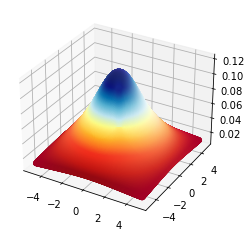

In [90]:
cProfile.run('finiteElement.graphResultsSparse()')

constructing b vector...
constructing Matrix...
Solving linear system...
Graphing solutions...
[[0.01125395 0.0113682  0.01148355 ... 0.01148355 0.0113682  0.01125395]
 [0.0113682  0.01148599 0.01160501 ... 0.01160501 0.01148599 0.0113682 ]
 [0.01148355 0.01160501 0.0117278  ... 0.0117278  0.01160501 0.01148355]
 ...
 [0.01148355 0.01160501 0.0117278  ... 0.0117278  0.01160501 0.01148355]
 [0.0113682  0.01148599 0.01160501 ... 0.01160501 0.01148599 0.0113682 ]
 [0.01125395 0.0113682  0.01148355 ... 0.01148355 0.0113682  0.01125395]]
[[8.81796052e-13 1.45376174e-12 2.37239607e-12 ... 2.37239607e-12
  1.45376174e-12 8.81796052e-13]
 [1.45376174e-12 2.39672563e-12 3.91122033e-12 ... 3.91122033e-12
  2.39672563e-12 1.45376174e-12]
 [2.37239607e-12 3.91122033e-12 6.38272661e-12 ... 6.38272661e-12
  3.91122033e-12 2.37239607e-12]
 ...
 [2.37239607e-12 3.91122033e-12 6.38272661e-12 ... 6.38272661e-12
  3.91122033e-12 2.37239607e-12]
 [1.45376174e-12 2.39672563e-12 3.91122033e-12 ... 3.9112203

<Figure size 432x288 with 0 Axes>

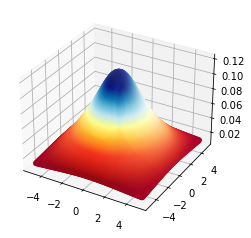

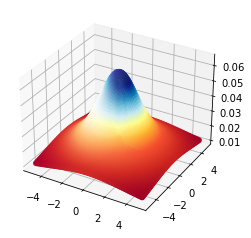

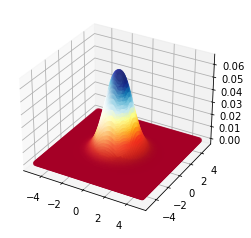

In [76]:
finiteElement.graphResultsSparse()
Test.plot(minX,maxX,minY,maxY,100,Test.erf_solution)
Test.plot(minX,maxX,minY,maxY,100,electronDensity)

constructing b vector...
constructing Matrix...
  (0, 0)	1800.0
  (0, 1)	-450.0
  (0, 151)	-450.0
  (1, 0)	-450.0
  (1, 1)	1800.0
  (1, 2)	-450.0
  (1, 152)	-450.0
  (2, 1)	-450.0
  (2, 2)	1800.0
  (2, 3)	-450.0
  (2, 153)	-450.0
  (3, 2)	-450.0
  (3, 3)	1800.0
  (3, 4)	-450.0
  (3, 154)	-450.0
  (4, 3)	-450.0
  (4, 4)	1800.0
  (4, 5)	-450.0
  (4, 155)	-450.0
  (5, 4)	-450.0
  (5, 5)	1800.0
  (5, 6)	-450.0
  (5, 156)	-450.0
  (6, 5)	-450.0
  (6, 6)	1800.0
  :	:
  (22794, 22794)	1800.0
  (22794, 22795)	-450.0
  (22795, 22644)	-450.0
  (22795, 22794)	-450.0
  (22795, 22795)	1800.0
  (22795, 22796)	-450.0
  (22796, 22645)	-450.0
  (22796, 22795)	-450.0
  (22796, 22796)	1800.0
  (22796, 22797)	-450.0
  (22797, 22646)	-450.0
  (22797, 22796)	-450.0
  (22797, 22797)	1800.0
  (22797, 22798)	-450.0
  (22798, 22647)	-450.0
  (22798, 22797)	-450.0
  (22798, 22798)	1800.0
  (22798, 22799)	-450.0
  (22799, 22648)	-450.0
  (22799, 22798)	-450.0
  (22799, 22799)	1800.0
  (22799, 22800)	-450.0
  (228

<Figure size 432x288 with 0 Axes>

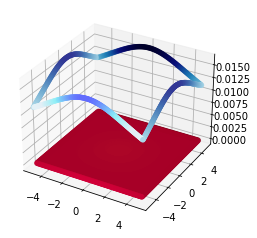

In [53]:
finiteElement.graphResultsSparse()

constructing b vector...
constructing Matrix...
Solving linear system...
Graphing solutions...
         470327 function calls (467969 primitive calls) in 64.298 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     1196    0.005    0.000    0.005    0.000 2533231469.py:14(boundaryCondition)
    22201    0.599    0.000    0.599    0.000 2979569269.py:197(getIntegralApprox)
    22801    0.010    0.000    0.010    0.000 2979569269.py:2(__init__)
        1    0.080    0.080    0.690    0.690 2979569269.py:205(constructBVector)
        1    0.000    0.000    0.001    0.001 2979569269.py:218(generateFlagged)
        1    0.000    0.000    0.000    0.000 2979569269.py:219(<listcomp>)
        1    0.000    0.000    0.000    0.000 2979569269.py:220(<listcomp>)
        1    0.000    0.000    0.000    0.000 2979569269.py:221(<listcomp>)
        1    0.000    0.000    0.000    0.000 2979569269.py:222(<listcomp>)
        1   14.624   14.

        8    0.000    0.000    0.000    0.000 axes3d.py:444(<genexpr>)
        3    0.000    0.000    0.000    0.000 axes3d.py:479(_unit_change_handler)
        1    0.000    0.000    0.000    0.000 axes3d.py:490(update_datalim)
        1    0.001    0.001    0.001    0.001 axes3d.py:535(set_zmargin)
        1    0.000    0.000    0.123    0.123 axes3d.py:55(__init__)
        1    0.000    0.000    0.002    0.002 axes3d.py:644(auto_scale_xyz)
        1    0.000    0.000    0.001    0.001 axes3d.py:658(autoscale_view)
        2    0.000    0.000    0.002    0.001 axes3d.py:727(set_xlim3d)
        2    0.000    0.000    0.000    0.000 axes3d.py:784(set_ylim3d)
        2    0.000    0.000    0.000    0.000 axes3d.py:842(set_zlim3d)
       17    0.000    0.000    0.000    0.000 axes3d.py:900(get_xlim3d)
       17    0.000    0.000    0.000    0.000 axes3d.py:904(get_ylim3d)
       18    0.000    0.000    0.000    0.000 axes3d.py:908(get_zlim3d)
        1    0.001    0.001    0.001    0.001

        2    0.000    0.000    0.000    0.000 compressed.py:125(_set_self)
        3    0.004    0.001    0.006    0.002 compressed.py:136(check_format)
      3/1    0.013    0.004   10.350   10.350 compressed.py:27(__init__)
  446/413    0.000    0.000    0.007    0.000 contextlib.py:114(__enter__)
  446/413    0.001    0.000    0.003    0.000 contextlib.py:123(__exit__)
      446    0.000    0.000    0.003    0.000 contextlib.py:261(helper)
        1    0.000    0.000    0.000    0.000 contextlib.py:398(_create_exit_wrapper)
        2    0.001    0.000    0.001    0.000 contextlib.py:408(__init__)
        1    0.000    0.000    0.000    0.000 contextlib.py:438(enter_context)
        1    0.000    0.000    0.000    0.000 contextlib.py:465(_push_cm_exit)
        1    0.000    0.000    0.000    0.000 contextlib.py:470(_push_exit_callback)
        2    0.000    0.000    0.000    0.000 contextlib.py:486(__enter__)
        2    0.001    0.000    0.001    0.000 contextlib.py:489(__exit__)
 

       78    0.000    0.000    0.003    0.000 lines.py:1020(set_color)
       78    0.000    0.000    0.000    0.000 lines.py:1032(set_drawstyle)
      110    0.001    0.000    0.001    0.000 lines.py:1067(set_linewidth)
      110    0.001    0.000    0.002    0.000 lines.py:1085(set_linestyle)
       82    0.000    0.000    0.003    0.000 lines.py:1133(set_marker)
      234    0.000    0.000    0.001    0.000 lines.py:1147(_set_markercolor)
       78    0.000    0.000    0.000    0.000 lines.py:1161(set_markeredgecolor)
       78    0.000    0.000    0.000    0.000 lines.py:1171(set_markerfacecolor)
       78    0.000    0.000    0.000    0.000 lines.py:1181(set_markerfacecoloralt)
       78    0.000    0.000    0.000    0.000 lines.py:1191(set_markeredgewidth)
       78    0.000    0.000    0.000    0.000 lines.py:1206(set_markersize)
      430    0.000    0.000    0.001    0.000 lines.py:1220(set_xdata)
      223    0.000    0.000    0.000    0.000 lines.py:1232(set_ydata)
       57

       12    0.000    0.000    0.000    0.000 ticker.py:1925(ge)
       12    0.000    0.000    0.004    0.000 ticker.py:1945(__init__)
       12    0.000    0.000    0.003    0.000 ticker.py:1986(_validate_steps)
       12    0.000    0.000    0.002    0.000 ticker.py:2001(_staircase)
       12    0.000    0.000    0.004    0.000 ticker.py:2007(set_params)
       12    0.001    0.000    0.008    0.001 ticker.py:2052(_raw_ticks)
       12    0.000    0.000    0.009    0.001 ticker.py:2112(__call__)
       12    0.000    0.000    0.009    0.001 ticker.py:2116(tick_values)
        3    0.001    0.000    0.001    0.000 ticker.py:2133(view_limits)
       12    0.000    0.000    0.003    0.000 ticker.py:221(format_ticks)
       12    0.000    0.000    0.001    0.000 ticker.py:224(<listcomp>)
       12    0.000    0.000    0.000    0.000 ticker.py:244(set_locs)
       50    0.000    0.000    0.000    0.000 ticker.py:253(fix_minus)
       21    0.000    0.000    0.000    0.000 ticker.py:265(_

       64    0.000    0.000    0.000    0.000 {method 'lower' of 'str' objects}
       20    0.000    0.000    0.000    0.000 {method 'lstrip' of 'str' objects}
      519    0.004    0.000    0.004    0.000 {method 'match' of 're.Pattern' objects}
      102    0.003    0.000    0.007    0.000 {method 'max' of 'numpy.ndarray' objects}
       50    0.000    0.000    0.003    0.000 {method 'min' of 'numpy.ndarray' objects}
        2    0.000    0.000    0.000    0.000 {method 'move_to_end' of 'collections.OrderedDict' objects}
        4    0.001    0.000    0.001    0.000 {method 'newbyteorder' of 'numpy.dtype' objects}
       14   10.108    0.722   10.108    0.722 {method 'nonzero' of 'numpy.ndarray' objects}
        2    0.000    0.000    0.000    0.000 {method 'pixel_access' of 'ImagingCore' objects}
        1    0.000    0.000    0.000    0.000 {method 'pop' of 'collections.deque' objects}
      807    0.000    0.000    0.000    0.000 {method 'pop' of 'dict' objects}
        8    0.00

<Figure size 432x288 with 0 Axes>

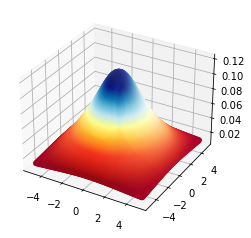

In [31]:
cProfile.run('finiteElement.graphResultsSparse()')

/var/folders/w9/rpt2vk6943b30y910f1djt500000gq/T/ipykernel_37629/633898350.py:565: RuntimeWarning: divide by zero encountered in double_scalars
  return 1/(4*np.pi*eps)*(1/(np.sqrt(x**2+y**2)))*scipy.special.erf(np.sqrt(x**2+y**2)/np.sqrt(2*a**2))
/var/folders/w9/rpt2vk6943b30y910f1djt500000gq/T/ipykernel_37629/633898350.py:565: RuntimeWarning: invalid value encountered in double_scalars
  return 1/(4*np.pi*eps)*(1/(np.sqrt(x**2+y**2)))*scipy.special.erf(np.sqrt(x**2+y**2)/np.sqrt(2*a**2))


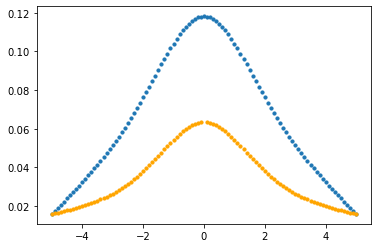

In [36]:
finiteElement.graphSlice(M//2, Test.erf_solution)

/var/folders/w9/rpt2vk6943b30y910f1djt500000gq/T/ipykernel_37629/119216815.py:576: RuntimeWarning: divide by zero encountered in double_scalars
  return 1/(4*np.pi*eps)*(1/(np.sqrt(x**2+y**2)))*scipy.special.erf(np.sqrt(x**2+y**2)/np.sqrt(2*a**2))
/var/folders/w9/rpt2vk6943b30y910f1djt500000gq/T/ipykernel_37629/119216815.py:576: RuntimeWarning: invalid value encountered in double_scalars
  return 1/(4*np.pi*eps)*(1/(np.sqrt(x**2+y**2)))*scipy.special.erf(np.sqrt(x**2+y**2)/np.sqrt(2*a**2))


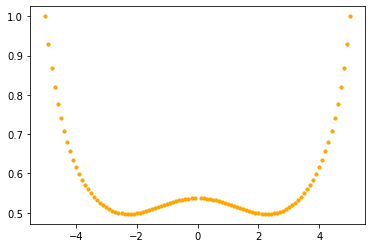

In [45]:
finiteElement.graphSliceErrorRatio(M//2, Test.erf_solution)

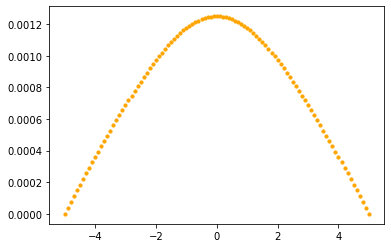

In [29]:
finiteElement.graphSliceError(M-1, Test.erf_solution)

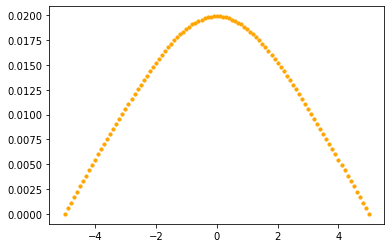

In [32]:
finiteElement.graphSliceError(M//6, Test.erf_solution)

In [35]:
finiteElement.extractSols(finiteElement.sols)[M//2,N//2]

0.1181544097526399

2.3999999999999995


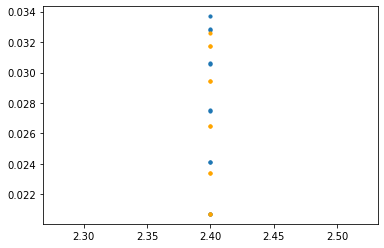

In [120]:
finiteElement.graphSlice2(N-1, Test.erf_solution)

In [95]:
finiteElement.extractSols(finiteElement.sols)

array([[0.01125395, 0.01242791, 0.01364742, 0.01477717, 0.01560643,
        0.01591549, 0.01560643, 0.01477717, 0.01364742, 0.01242791,
        0.01125395],
       [0.01242791, 0.0153442 , 0.01826046, 0.02098671, 0.02304656,
        0.02379657, 0.02294326, 0.02085957, 0.0181658 , 0.01529686,
        0.01242791],
       [0.01364742, 0.01826045, 0.02306255, 0.02785552, 0.03177489,
        0.03325414, 0.03149669, 0.02754912, 0.0228591 , 0.0181658 ,
        0.01364742],
       [0.01477717, 0.02098669, 0.02785549, 0.0354579 , 0.04250618,
        0.0453835 , 0.04193498, 0.03491188, 0.02754909, 0.02085955,
        0.01477717],
       [0.01560643, 0.0230465 , 0.03177483, 0.04250616, 0.05380438,
        0.058945  , 0.05314443, 0.04193489, 0.03149664, 0.02294322,
        0.01560643],
       [0.01591549, 0.02379651, 0.03325409, 0.04538347, 0.05894498,
        0.06573348, 0.05894498, 0.04538347, 0.03325409, 0.02379651,
        0.01591549],
       [0.01560643, 0.02294322, 0.03149664, 0.04193489, 0.

# Hydrogen Atom– 1s orbital

In [118]:
finiteElement_1s=FEM(N, M, minX, maxX, minY, maxY, electronDensity_hydrogen1s, eps, boundaryCondition)

(51, 51)


<Figure size 432x288 with 0 Axes>

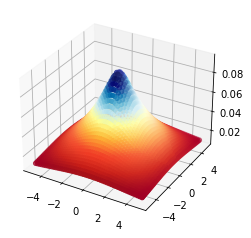

In [119]:
finiteElement_1s.graphResults()

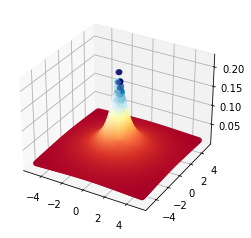

In [123]:
Test.plot(minX, maxX, minY, maxY, 100,Test.hydrogen_1s_solution)

(51, 51)


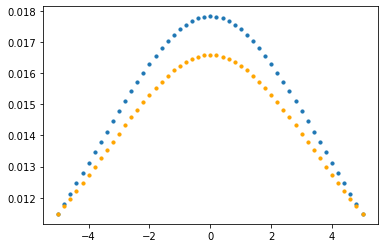

In [120]:
finiteElement_1s.graphSlice(1, Test.hydrogen_1s_solution)

(51, 51)


/var/folders/w9/rpt2vk6943b30y910f1djt500000gq/T/ipykernel_76888/3356704814.py:447: RuntimeWarning: divide by zero encountered in double_scalars
  return (1/(4*np.pi*eps*a**2))*(a**2/(np.sqrt(x**2+y**2))-(a**2/(np.sqrt(x**2+y**2))-a)*np.exp(-2*(np.sqrt(x**2+y**2))/a)) if r>0 else (1/(4*np.pi*eps*a**2))*(-a**2/(np.sqrt(x**2+y**2))-(-a**2/np.sqrt(x**2+y**2)-a)*np.exp(2*np.sqrt(x**2+y**2)/a))
/var/folders/w9/rpt2vk6943b30y910f1djt500000gq/T/ipykernel_76888/3356704814.py:447: RuntimeWarning: invalid value encountered in double_scalars
  return (1/(4*np.pi*eps*a**2))*(a**2/(np.sqrt(x**2+y**2))-(a**2/(np.sqrt(x**2+y**2))-a)*np.exp(-2*(np.sqrt(x**2+y**2))/a)) if r>0 else (1/(4*np.pi*eps*a**2))*(-a**2/(np.sqrt(x**2+y**2))-(-a**2/np.sqrt(x**2+y**2)-a)*np.exp(2*np.sqrt(x**2+y**2)/a))


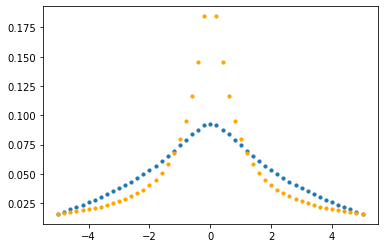

In [121]:
finiteElement_1s.graphSlice(M//2, Test.hydrogen_1s_solution)

# Micelleanous tests

In [77]:
for arr in finiteElement.finiteElements:
    for fin in arr:
        print(fin.config, end = '')
    print()

010101010
101010101
010101010
101010101
010101010
101010101
010101010
101010101
010101010


In [1126]:
cProfile.run('finiteElement.constructBVector()')

         398790508 function calls (397479352 primitive calls) in 400.977 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
 24510003   81.790    0.000   81.790    0.000 1213147394.py:17(electronDensity)
 24510003   51.583    0.000  267.550    0.000 870614964.py:120(evaluate)
 14793831   21.558    0.000   21.558    0.000 870614964.py:14(area)
 24510003   29.154    0.000  378.494    0.000 870614964.py:158(integrand)
     7301    0.154    0.000  400.980    0.055 870614964.py:161(getIntegral)
   327789    0.042    0.000    0.042    0.000 870614964.py:167(<lambda>)
        1    0.046    0.046  401.030  401.030 870614964.py:169(constructBVector)
 14793831   27.597    0.000   27.597    0.000 870614964.py:19(area_pt)
 14801132    3.997    0.000    3.997    0.000 870614964.py:2(__init__)
 88785560  113.658    0.000  113.658    0.000 870614964.py:27(is_in)
 88785560   41.479    0.000  208.286    0.000 870614964.py:34(evaluate)
        

In [328]:
b

array([1.55151627e-08, 2.03005076e-06, 4.15905038e-06, 5.37416210e-05,
       2.68805763e-05, 5.37416210e-05, 4.15905038e-06, 2.03005076e-06,
       1.55151627e-08, 4.04959042e-07, 3.95469260e-05, 1.02286066e-04,
       1.07639908e-03, 6.47880260e-04, 1.07639908e-03, 1.02286066e-04,
       3.95469260e-05, 4.04959042e-07, 4.15909076e-06, 3.16266299e-04,
       1.00633186e-03, 8.84764089e-03, 6.26648911e-03, 8.84764089e-03,
       1.00633186e-03, 3.16266299e-04, 4.15909076e-06, 1.68442203e-05,
       1.07639927e-03, 3.96279664e-03, 3.07609608e-02, 2.43921457e-02,
       3.07609608e-02, 3.96279664e-03, 1.07639927e-03, 1.68442203e-05,
       2.68805845e-05, 1.61157981e-03, 6.26648908e-03, 4.64351063e-02,
       3.84252238e-02, 4.64351063e-02, 6.26648908e-03, 1.61157981e-03,
       2.68805845e-05, 1.68544646e-05, 1.07639927e-03, 3.96684320e-03,
       3.07609608e-02, 2.44218537e-02, 3.07609608e-02, 3.96684320e-03,
       1.07639927e-03, 1.68544646e-05, 4.15909076e-06, 3.16266299e-04,
      

In [322]:
b.shape

(81,)

In [569]:
finiteElement.M-1

9

In [567]:
te=finiteElement.getBoundaryIndicies1D(finiteElement.M-1,finiteElement.N-1)

In [568]:
te

(array([ 1, 73,  2, 74,  3, 75,  4, 76,  5, 77,  6, 78,  7, 79]),
 array([ 9, 17, 18, 26, 27, 35, 36, 44, 45, 53, 54, 62, 63, 71]))

In [305]:
finiteElement.getBoundaryXY(te, finiteElement.M-1,finiteElement.N-1).shape

rows:  8
cols:,  8
(0, 0)
(0, 8)
(1, 0)
(1, 8)
(2, 0)
(2, 8)
(3, 0)
(3, 8)
(4, 0)
(4, 8)
(5, 0)
(5, 8)
(6, 0)
(6, 8)
(7, 0)
(7, 8)
(8, 0)
(8, 8)
(0, 1)
(8, 1)
(0, 2)
(8, 2)
(0, 3)
(8, 3)
(0, 4)
(8, 4)
(0, 5)
(8, 5)
(0, 6)
(8, 6)
(0, 7)
(8, 7)


(32, 2)

In [159]:
Test.erf_solution(5,-5)

0.011253953951946524

In [457]:
finiteElement.getIntegral(Point(5, 5))

0.039283270476846995

In [458]:
cProfile.run('finiteElement.getIntegral(Point(5, 5))')

         60288 function calls (60204 primitive calls) in 0.087 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     3759    0.013    0.000    0.013    0.000 2671086426.py:18(electronDensity)
     3759    0.008    0.000    0.065    0.000 2815419501.py:127(evaluate)
     3759    0.006    0.000    0.006    0.000 2815419501.py:14(area)
     3759    0.004    0.000    0.083    0.000 2815419501.py:165(integrand)
        1    0.000    0.000    0.087    0.087 2815419501.py:168(getIntegral)
       21    0.000    0.000    0.000    0.000 2815419501.py:174(<lambda>)
     3759    0.006    0.000    0.006    0.000 2815419501.py:19(area_pt)
     3760    0.001    0.000    0.001    0.000 2815419501.py:2(__init__)
    12471    0.034    0.000    0.034    0.000 2815419501.py:34(is_in)
    12471    0.009    0.000    0.056    0.000 2815419501.py:41(evaluate)
        1    0.000    0.000    0.087    0.087 <string>:1(<module>)
     22/1    0.000    0

In [42]:
cProfile.run('finiteElement_1s.getIntegral(Point(6, 5))')

         23805 function calls (23721 primitive calls) in 0.028 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     1239    0.003    0.000    0.019    0.000 1083853788.py:120(evaluate)
     1239    0.002    0.000    0.002    0.000 1083853788.py:14(area)
     1239    0.002    0.000    0.027    0.000 1083853788.py:158(integrand)
        1    0.000    0.000    0.028    0.028 1083853788.py:161(getIntegral)
       21    0.000    0.000    0.000    0.000 1083853788.py:167(<lambda>)
     1239    0.002    0.000    0.002    0.000 1083853788.py:19(area_pt)
     5350    0.007    0.000    0.007    0.000 1083853788.py:27(is_in)
     5350    0.003    0.000    0.015    0.000 1083853788.py:34(evaluate)
     1240    0.000    0.000    0.000    0.000 3847819063.py:2(__init__)
     1239    0.006    0.000    0.006    0.000 4224490791.py:20(electronDensity_hydrogen1s)
        1    0.000    0.000    0.028    0.028 <string>:1(<module>)
     22/1   

In [118]:
finiteElement.getIntegral(Point(6, 5))

0.00010224424095003971

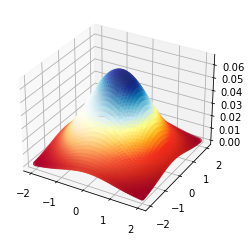

In [469]:
Test.plot(-2, 2, -2, 2, 50, electronDensity)

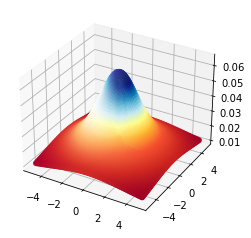

In [447]:
rgb.shape

(10, 10, 4)

In [457]:
new_img = rgb.transpose((2, 0, 1))
# Dimensions: [3, m, n]
new_img = rgb.reshape(rgb.shape[0]*rgb.shape[1], rgb.shape[2])


In [458]:
new_img

array([[0.68481796, 0.        , 0.16496235, 1.        ],
       [0.75905341, 0.05379805, 0.18212881, 1.        ],
       [0.84628762, 0.14192815, 0.20761217, 1.        ],
       [0.92329873, 0.27363132, 0.23586449, 1.        ],
       [0.95482765, 0.39779499, 0.29295771, 1.        ],
       [0.95482765, 0.39779499, 0.29295771, 1.        ],
       [0.92329873, 0.27363132, 0.23586449, 1.        ],
       [0.84628762, 0.14192815, 0.20761217, 1.        ],
       [0.75905341, 0.05379805, 0.18212881, 1.        ],
       [0.68481796, 0.        , 0.16496235, 1.        ],
       [0.73246635, 0.04995992, 0.16913513, 1.        ],
       [0.84716872, 0.17687766, 0.19161746, 1.        ],
       [0.94752375, 0.45880295, 0.30754923, 1.        ],
       [0.98984129, 0.84021039, 0.50778829, 1.        ],
       [0.9978578 , 0.93506363, 0.66781057, 1.        ],
       [0.9978578 , 0.93506363, 0.66781057, 1.        ],
       [0.98984129, 0.84021039, 0.50778829, 1.        ],
       [0.94752375, 0.45880295,

In [135]:
fin=FiniteElement(0, 0, 1, 1, 2)

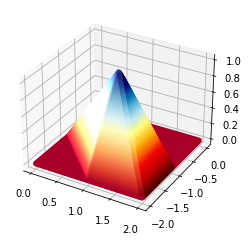

In [137]:
fin=FiniteElement(0, 0, 1, 1, 2)
Test.plot(0, 2, -2, 0,100,fin.evaluate)

In [115]:
integrate.dblquad(fin.evaluate, -2, 0,lambda x: 0, lambda x: 2)[0]

1.3333333501027889

In [784]:
fin.evaluate(0.6,-1.5)

0.09999999999999987

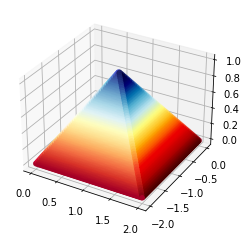

In [764]:
Test.plot(0, 2, -2, 0,100,fin.evaluate)

In [775]:
fin.evaluate(0.55,-1.5)

0.5

In [101]:
fin.evaluate(1,-1)

1

In [83]:
fin.evaluate(1,-1)

4.0

0.6666666499049005

In [573]:
fin.evaluate(1.8,-1.8)

0

In [607]:
integrate.dblquad(electronDensity, -2, 0,lambda x: 0, lambda x: 2,epsabs=1e-8)[0]

0.090866060540632

In [ ]:
Test.plot(0, 0.4, -0.4, 0,100,finiteElement.finiteElements[5, 5].evaluate)
Test.plot(0, 0.4, -0.4, 0,100,electronDensity)

In [13]:
def lol(x, y):
    return electronDensity(x, y)*fin.evaluate(x, y)

In [636]:
test=[(integrate.dblquad(lol, -2, 0,lambda x: 0, lambda x: 2,epsabs=1e-8*10**i)[0]) for i in range(0, 7)]

In [637]:
test

[0.0016191353028300304,
 0.0016191286222514505,
 0.0016191289772780834,
 0.00161919315870105,
 0.0016219522329523855,
 0.001613626045322107,
 0.0015999807360674192]

In [640]:
1e-8*10**4

0.0001

In [29]:
cProfile.run('integrate.dblquad(lol, -2, 0,lambda x: 0, lambda x: 2)[0]')

         473690 function calls (473438 primitive calls) in 0.569 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    38073    0.113    0.000    0.113    0.000 1226877424.py:16(electronDensity)
    38073    0.027    0.000    0.546    0.000 2234026894.py:1(lol)
    17993    0.071    0.000    0.071    0.000 74039619.py:14(area)
    17993    0.031    0.000    0.031    0.000 74039619.py:18(area_pt)
    17993    0.005    0.000    0.005    0.000 74039619.py:2(__init__)
   152292    0.192    0.000    0.192    0.000 74039619.py:23(is_in)
   152292    0.061    0.000    0.361    0.000 74039619.py:35(evaluate)
    38073    0.045    0.000    0.406    0.000 74039619.py:84(evaluate)
       63    0.000    0.000    0.000    0.000 <string>:1(<lambda>)
        1    0.000    0.000    0.569    0.569 <string>:1(<module>)
     64/1    0.000    0.000    0.568    0.568 quadpack.py:445(_quad)
     64/1    0.000    0.000    0.568    0.568 quadpack.py

In [622]:
integrate.dblquad(lol, -2, 0,lambda x: 0, lambda x: 2,epsabs=1e-4)[0]

0.0016219522329523855

In [36]:
def integrand(x, y):
    return (1/finiteElement.eps)*finiteElement.electronDensity(x,y)*finiteElement.finiteElements[5, 5].evaluate(x, y)

In [40]:
integrate.dblquad(integrand, -2, 0,lambda x: 0, lambda x: 2,epsabs=1e-5)[0]

0.00161919315870105

In [ ]:
integrate.dblquad(self.integrand, minY, maxY, lambda x: minX, lambda x: maxX, args=[p1],epsabs=1e-4)[0]